In [2]:
import numpy as np
from numpy import random
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
from functions_2 import LoadBatch, montage 

In [90]:
def separete_file(filename):
    data = filename[b'data']
    labels = filename[b'labels']
    y=np.array(filename[b'labels'])#(10000,)
    one_hot = np.zeros((len(y), 10), dtype=int)
    one_hot[np.arange(len(y)), y] = 1 #(10000,10)
    
    return np.transpose(y), np.transpose(one_hot), np.transpose(data)

def normalize(data, column_means, column_stds):# we want to normalize train, val, and test with the training parameters.
    column_means = data.mean(axis=0)#in all cases we normalize with the training set mean
    column_stds = data.std(axis=0)#and training set sd
    data = data - column_means
    data = data / column_stds
    return data

def init_parameters(mean, std, size):
    return random.normal(mean, std, size)#L1: W(m=number of hidden nodes x d=number of inputs), b = (m x 1)
                                         #L2: W(K=number of classes x m), b = (K x 1)
    
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    P, _ = EvaluateClassifier(X, W1, b1, W2, b2)
    estimated_y = np.argmax(P, axis=0)
    accurancy = accuracy_score(y, estimated_y)
    return accurancy

    
def EvaluateClassifier(X, W1, b1, W2, b2):
    s1 = np.dot(W1,X)+ b1
    s1[s1 <= 0] = 0 #ReLu activation function
    s = np.dot(W2,s1)+ b2
    P = np.exp(s)/np.sum(np.exp(s), axis=0)
    return P, s1

def ComputeCost(X, Y, W1, b1, W2, b2, lambd):
    P, _ = EvaluateClassifier(X, W1, b1, W2, b2)
    regulaizer = lambd*(np.sum(np.square(W1)) + np.sum(np.square(W2)))
    N = X.shape[1]
    square_matrix = np.multiply(Y, np.log(P))
    sum_diag = -np.sum(square_matrix) 
    cost = (1/N) * sum_diag + regulaizer
    return cost

def ComputeGradients(X, Y, W1, b1, W2, b2, lambd):
    P, h = EvaluateClassifier(X, W1, b1, W2, b2)
    G_batch = -(Y - P)
    N = X.shape[1]
    grad_W2 = np.add(np.dot(G_batch,np.transpose(h)) / N , 2*lambd*W2)
    grad_b2 = np.dot(G_batch,np.ones((h.shape[1],1))) / N
    G_batch = np.dot(np.transpose(W2), G_batch)
    G_batch = np.multiply(G_batch, h>0)
    grad_W1 = np.add(np.dot(G_batch,np.transpose(X)) / N , 2*lambd*W1)
    grad_b1 = np.dot(G_batch,np.ones((X.shape[1],1))) / N
    return grad_W1, grad_b1, grad_W2, grad_b2


def ComputeGradsNum(X, Y, W1, b1, W2, b2, lambda_, h=0.00001):
    grad_W2 = np.zeros(shape=W2.shape)
    grad_b2 = np.zeros(shape=b2.shape)
    grad_W1 = np.zeros(shape=W1.shape)
    grad_b1 = np.zeros(shape=b1.shape)
    c = ComputeCost(X, Y, W1, b1, W2, b2, lambda_)

    for i in range(b1.shape[0]):
        b1_try = b1.copy()
        b1_try[i,0] = b1_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1_try, W2, b2, lambda_)
        grad_b1[i,0] = (c2-c)/h

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1_try = W1.copy()
            W1_try[i,j] = W1_try[i,j]+h
            c2 = ComputeCost(X, Y, W1_try, b1, W2, b2, lambda_)
            grad_W1[i,j] = (c2-c)/h

    for i in range(b2.shape[0]):
        b2_try = b2.copy()
        b2_try[i,0] = b2_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1, W2, b2_try, lambda_)
        grad_b2[i,0] = (c2-c)/h

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = W2.copy()
            W2_try[i,j] = W2_try[i,j]+h
            c2 = ComputeCost(X, Y, W1, b1, W2_try, b2, lambda_)
            grad_W2[i,j] = (c2-c)/h

    return grad_W2, grad_b2, grad_W1, grad_b1

def compare_gradients(g1,g2, eps):
    num = abs(g1-g2).sum()
    denom = max(eps, abs(g1+g2).sum())
    return num/denom 


def MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W1, b1, W2, b2, lambd, n_s,CLR_bool = False):
    N = X.shape[1]
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    etas = []
    k_list1 = list(range(0, n_s, 1))
    k_list2 = list(range(n_s, 0, -1))
    k_list = np.concatenate([k_list1, k_list2], axis=0)
    cycle_idx = 0
    
    for epoch in range(n_epochs):
    
        for batch in range(0, N, n_batch):    
            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:,batch:batch+n_batch], Y[:,batch:batch+n_batch], 
                                                                  W1, b1, W2, b2, lambd)
            if CLR_bool:
                interCounter = k_list[cycle_idx]      
                cycle_idx += 1
                if cycle_idx >= len(k_list):
                    cycle_idx = 0
                eta = CLR(interCounter, 1e-5, 1e-1, n_s)
                etas.append(eta)
            
            W1 -= eta*grad_W1
            b1 -= eta*grad_b1
            W2 -= eta*grad_W2
            b2 -= eta*grad_b2
            
        train_acc.append(ComputeAccuracy(X, y, W1, b1, W2, b2))
        train_loss.append(ComputeCost(X, Y, W1, b1, W2, b2, lambd))

        val_acc.append(ComputeAccuracy(X_val, y_val, W1, b1, W2, b2))
        val_loss.append(ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambd))
        
    return W1, b1, W2, b2, train_acc, train_loss, val_acc, val_loss, etas


def CLR(iterCounter, eta_min, eta_max, n_s):   
    cycle = math.floor(iterCounter/(2 * n_s)) #current cycle --> current 'trinagle' 
    
    if iterCounter >= 2*n_s*cycle and iterCounter < (2*cycle + 1)*n_s:#if t is located in the first half of the triangle
        eta = eta_min + ((iterCounter - 2*n_s*cycle)*(eta_max - eta_min) / n_s)
        
    elif iterCounter >= (2*cycle + 1)*n_s and iterCounter < 2*(cycle + 1)*n_s:#if t is located in the second half of the triangle
        eta = eta_max - ((iterCounter - (2*cycle+1)*n_s)*(eta_max - eta_min) / n_s)
        
    return eta


def grid_search(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W1, b1, W2, b2, lambdas, n_s):

    grid_search_array = pd.DataFrame({'lambda':[], 'valid_accurancy':[]})
    for lambd in lambdas:

        _, _, _, _,train_acc, train_loss, val_acc, val_loss, _ =MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val,n_batch,
                                                                   eta, n_epochs, W1, b1, W2, b2, lambd, 
                                                                   n_s,CLR_bool = True)
        
        grid_search_array = grid_search_array.append({'lambda':lambd, 'valid_accurancy':max(val_acc)}, ignore_index=True)
        
    grid_search_array.sort_values(['valid_accurancy'], inplace=True)
    return grid_search_array


def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, color='red', label='train loss: '+str(round(train_loss[-1], 3)))
    plt.plot(val_loss, color='blue', label='validation loss: '+str(round(val_loss[-1], 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.show()
    
def plot_accurancy(train_acc, val_acc):
    plt.plot(train_acc, color='red', label='train accurancy: '+str(round(max(train_acc), 3)))
    plt.plot(val_acc, color='blue', label='validation accurancy: '+str(round(max(val_acc), 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accurancy")
    #plt.show()
    


comparing gW1 and g_W1: the relative error is equal to 1.1893964378689202e-06
comparing gb1 and g_b1: the relative error is equal to 1.0871827791390477e-06
comparing gW2 and g_W2: the relative error is equal to 1.7249730486430448e-07
comparing gb2 and g_b2: the relative error is equal to 5.175830698916054e-06


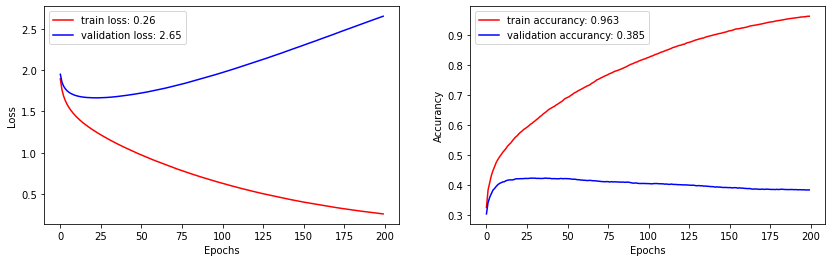

In [3]:
train = LoadBatch('data_batch_1')
validation = LoadBatch('data_batch_2')
test = LoadBatch('test_batch')

#separate the file into: 
#y : a vector of length n containing the label for each image
#one_hot : one-hot representation, has size Kxn
#images: contains the image pixel data, has size d×n
y_train,one_hot_train,images_train=separete_file(train)
y_valid,one_hot_valid,images_valid=separete_file(validation)
y_test,one_hot_test,images_test=separete_file(test)

#normalize the train, val, and test data with the train's means and standard deviations
column_means = images_train.mean(axis=0)#train's means
column_stds = images_train.std(axis=0)#train's stds
images_train_norm = normalize(images_train, column_means, column_stds)
images_valid_norm = normalize(images_valid, column_means, column_stds)
images_test_norm = normalize(images_test, column_means, column_stds)

#Initialize the parametrs
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

#Forward pass, returns the final probabilities values and the intermediary activation values
P, h = EvaluateClassifier(images_train_norm, W1, b1, W2, b2) #P->(Kxd), h-> (mxd)

#Compute the gradients and check if they are correct:
X = images_train_norm[:20,:10]
Y = one_hot_train[:,:10]
P, H = EvaluateClassifier(X, W1[:,:20], b1, W2, b2)

gW1, gb1, gW2, gb2 = ComputeGradients(X, Y, W1[:,:20], b1, W2, b2, 0)
g_W2, g_b2, g_W1, g_b1 = ComputeGradsNum(X, Y, W1[:,:20], b1, W2, b2, 0, h=1e-05)

print('comparing gW1 and g_W1: the relative error is equal to', str(compare_gradients(g_W1,gW1, 1e-05)))
print('comparing gb1 and g_b1: the relative error is equal to', str(compare_gradients(g_b1,gb1, 1e-05)))
print('comparing gW2 and g_W2: the relative error is equal to', str(compare_gradients(g_W2,gW2, 1e-05)))
print('comparing gb2 and g_b2: the relative error is equal to', str(compare_gradients(g_b2,gb2, 1e-05)))

#Sanity check: check if you can overfit to the training data and get a very low loss on the training data after
#training for a sufficient number of epochs (∼200) and with a reasonable η
W1, b1, W2, b2, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.005, 200, W1, b1, W2, b2, 0, n_s=None, CLR_bool=False)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

### Train your network with cyclical learning rates: here n_s (step size) = 500, thus one cycle takes 10 epochs

In [4]:
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

W1, b1, W2, b2, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.005, 10, W1, b1, W2, b2, 0.01, n_s=500, CLR_bool=True)

Text(0, 0.5, 'Accurancy')

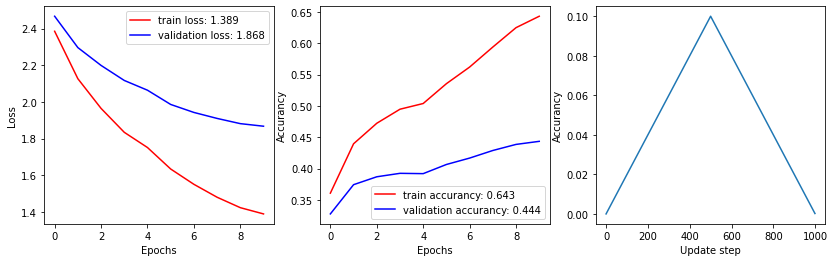

In [5]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

### Train your network with cyclical learning rates: here n_s (step size) = 800, thus one cycle takes 16 epochs

In [4]:
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

W1, b1, W2, b2, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.001, 48, W1, b1, W2, b2, 0.01, n_s = 800, CLR_bool=True)

Text(0, 0.5, 'Accurancy')

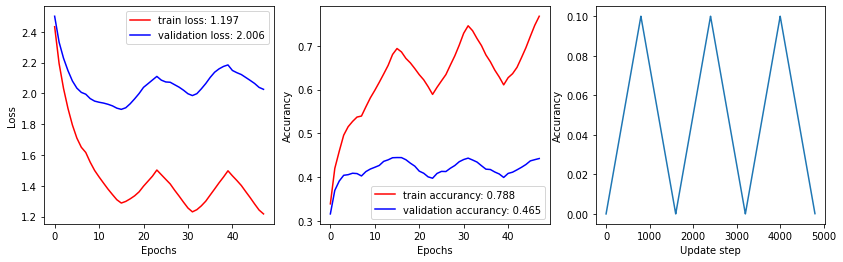

In [5]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

# Exercise 4: Train your network for real

In [93]:
batch1 = LoadBatch('data_batch_1')
batch2 = LoadBatch('data_batch_2')
batch3 = LoadBatch('data_batch_3')
batch4 = LoadBatch('data_batch_4')
batch5 = LoadBatch('data_batch_5')
test = LoadBatch('test_batch')

y_train1,one_hot_train1,images_train1=separete_file(batch1)
y_train2,one_hot_train2,images_train2=separete_file(batch2)
y_train3,one_hot_train3,images_train3=separete_file(batch3)
y_train4,one_hot_train4,images_train4=separete_file(batch4)
y_train5,one_hot_train5,images_train5=separete_file(batch5)
y_test,one_hot_test,images_test=separete_file(test)

#Concatenate the five batch files to get the entire dataset
CIFAR10 = np.concatenate((images_train1, images_train2, images_train3, images_train4, images_train5), axis = 1)#3072x50000
LABELS = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5), axis = 0)#50000,1
ONE_HOT = np.concatenate((one_hot_train1, one_hot_train2, one_hot_train3, one_hot_train4, one_hot_train5), axis = 1)#10x50000


# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(CIFAR10.shape[1]), 5000, replace=False)
CIFAR10_val = CIFAR10[:,indexes_validation]
ONE_HOT_val = ONE_HOT[:,indexes_validation]#10x5000
LABELS_val = [LABELS[i] for i in indexes_validation]#5000x1

# Subset the training set
CIFAR10_train = np.delete(CIFAR10, indexes_validation, 1)
ONE_HOT_train = np.delete(ONE_HOT, indexes_validation, 1)#10x45000
LABELS_TRAIN = [LABELS[i] for i in range(CIFAR10.shape[1]) if i not in indexes_validation]#45000x1

#Normalize the train, val, and test data with the train's means and standard deviations
column_means = CIFAR10_train.mean(axis=0)#train's means
column_stds = CIFAR10_train.std(axis=0)#train's stds
CIFAR10_train_norm = normalize(CIFAR10_train, column_means, column_stds)#3072x45000
CIFAR10_val_norm = normalize(CIFAR10_val, column_means, column_stds)#3072x5000
CIFAR10_test_norm = normalize(images_test, column_means, column_stds)#3072x10000


In [16]:
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)

np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_lambdas_coarse = list(10**l)
list_lambdas_coarse.sort()

grdid_array  = grid_search(CIFAR10_train_norm, ONE_HOT_train, LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                           100, 0.001, 36, W1, b1, W2, b2, list_lambdas_coarse, n_s)


In [17]:
grdid_array

,lambda,valid_accurancy
9,0.071557,0.4004
8,0.036906,0.4452
2,0.000563,0.4470
1,0.000495,0.4508
0,0.000342,0.4650
3,0.001512,0.4672
4,0.001568,0.4706
5,0.002577,0.4878
6,0.003833,0.4954
7,0.007257,0.5000


In [24]:
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)


list_lambdas_coarse = np.arange(0.006,0.009, 0.0005)


grdid_array  = grid_search(CIFAR10_train_norm, ONE_HOT_train, LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                           100, 0.001, 72, W1, b1, W2, b2, list_lambdas_coarse, n_s)

In [25]:
grdid_array

,lambda,valid_accurancy
5,0.0085,0.5090
2,0.0070,0.5104
4,0.0080,0.5116
3,0.0075,0.5130
0,0.0060,0.5150
1,0.0065,0.5162


### Train on the entire dataset with the best set of parameters

In [99]:
batch1 = LoadBatch('data_batch_1')
batch2 = LoadBatch('data_batch_2')
batch3 = LoadBatch('data_batch_3')
batch4 = LoadBatch('data_batch_4')
batch5 = LoadBatch('data_batch_5')
test = LoadBatch('test_batch')

y_train1,one_hot_train1,images_train1=separete_file(batch1)
y_train2,one_hot_train2,images_train2=separete_file(batch2)
y_train3,one_hot_train3,images_train3=separete_file(batch3)
y_train4,one_hot_train4,images_train4=separete_file(batch4)
y_train5,one_hot_train5,images_train5=separete_file(batch5)
y_test,one_hot_test,images_test=separete_file(test)

#Concatenate the five batch files to get the entire dataset
CIFAR10 = np.concatenate((images_train1, images_train2, images_train3, images_train4, images_train5), axis = 1)#3072x50000
LABELS = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5), axis = 0)#50000,1
ONE_HOT = np.concatenate((one_hot_train1, one_hot_train2, one_hot_train3, one_hot_train4, one_hot_train5), axis = 1)#10x50000


# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(CIFAR10.shape[1]), 1000, replace=False)
CIFAR10_val = CIFAR10[:,indexes_validation]
ONE_HOT_val = ONE_HOT[:,indexes_validation]#10x1000
LABELS_val = [LABELS[i] for i in indexes_validation]#1000x1

# Subset the training set
CIFAR10_train = np.delete(CIFAR10, indexes_validation, 1)
ONE_HOT_train = np.delete(ONE_HOT, indexes_validation, 1)#10x49000
LABELS_TRAIN = [LABELS[i] for i in range(CIFAR10.shape[1]) if i not in indexes_validation]#49000x1

#Normalize the train, val, and test data with the train's means and standard deviations
column_means = CIFAR10_train.mean(axis=0)#train's means
column_stds = CIFAR10_train.std(axis=0)#train's stds
CIFAR10_train_norm = normalize(CIFAR10_train, column_means, column_stds)#3072x49000
CIFAR10_val_norm = normalize(CIFAR10_val, column_means, column_stds)#3072x1000
CIFAR10_test_norm = normalize(images_test, column_means, column_stds)#3072x10000

In [126]:
m = 50                             #number of hidden nodes
d = images_train_norm.shape[0]     #number of input nodes
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 #sd to initialize W2
K = one_hot_train.shape[0]         #number of classes
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)

W1_, b1_, W2_, b2_, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(CIFAR10_train_norm, ONE_HOT_train, 
                                                                               LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                               LABELS_val,100, 0.001, 58, W1, b1, W2, b2,
                                                                               0.0065, n_s, CLR_bool=True)

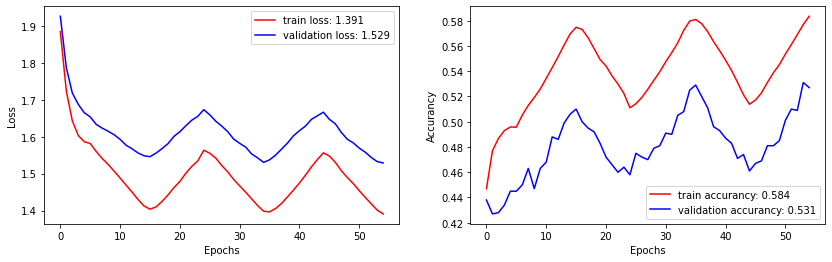

In [127]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

In [137]:
test_data = CIFAR10_test_norm
test_labels = test[b'labels']
ComputeAccuracy(test_data, test_labels, W1_, b1_, W2_, b2_)

0.5063